In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [14]:
here = Path.cwd()
root = next(p for p in [here, *here.parents] if (p / "data" / "processed").exists())

#creating 2 columns to identify source file and if ios or android
df_v3 = pd.read_csv(root / "data" / "processed" / "merged" / "state1_clean.csv", header=0)
df_v3.head() 

,is_ios,source_file,eventType,eventSampleSpeed,eventDurationSeconds,eventMilesDriven,eventSensorDetectionMthd,eventGPSSignalStrength,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius
0,0,android_turns.csv,4.0,10.394929,7.244125,0.016991,2.0,1.480796,17.323687,6.789408,1.046972,9.521707,69.319600,22.941639
1,0,android_turns.csv,4.0,9.401910,7.497719,0.016103,2.0,1.693853,6.197542,10.101060,1.153392,11.245602,84.723694,20.737572
2,0,android_turns.csv,5.0,11.290954,4.244563,0.008359,2.0,21.173470,11.229438,9.081976,5.708309,24.616348,105.462135,18.996666
3,0,android_turns.csv,5.0,12.743101,3.173500,0.007654,1.0,15.306123,10.714942,13.421639,3.099853,17.929585,57.610783,23.959110
4,0,android_turns.csv,5.0,8.986107,5.990321,0.013587,0.0,19.387754,2.729067,20.937756,1.197121,2.787075,16.806042,91.713660


In [15]:
df_v3.drop(columns=['source_file'], inplace=True)

sub_df_left = df_v3[df_v3['eventType'] == 4]
sub_df_left = sub_df_left.drop(columns=['is_ios', 'eventType', 'eventSampleSpeed', 'eventSensorDetectionMthd', 'eventGPSSignalStrength'])

In [16]:
sub_df_left.columns.tolist()

['eventDurationSeconds',
 'eventMilesDriven',
 'eventStartSpeed',
 'eventEndSpeed',
 'memsMedianHorizontalNorm',
 'gyro_angular_change_per_second',
 'gyroAngleChange',
 'mems_radius']

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
scaler =StandardScaler()

X_features = sub_df_left
features = scaler.fit_transform(X_features)
scaled_df = pd.DataFrame(features,columns=X_features.columns)

# Print the scaled data
X = scaled_df.values
scaled_df.head(2)


,eventDurationSeconds,eventMilesDriven,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius
0,0.736331,-0.309477,0.313634,-1.341506,-0.911557,-0.575256,0.135539,-0.299123
1,0.824479,-0.355795,-0.939736,-0.913205,-0.808508,-0.267585,0.539189,-0.371133


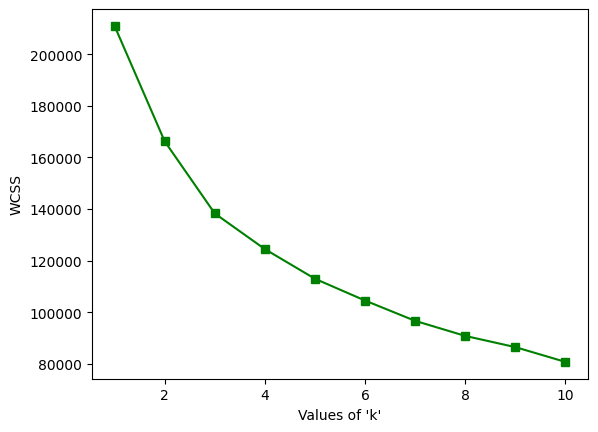

In [18]:
wcss = {} 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X) 
    wcss[i] = kmeans.inertia_
    
plt.plot(wcss.keys(), wcss.values(), 'gs-')
plt.xlabel("Values of 'k'")
plt.ylabel('WCSS')
plt.show()

In [20]:
results = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features)

    sil = silhouette_score(features, labels)
    ch = calinski_harabasz_score(features, labels)

    results.append((k, sil, ch))

for r in results:
    print(f"k={r[0]} | Silhouette={r[1]:.3f} | CH Score={r[2]:.0f}")

k=2 | Silhouette=0.302 | CH Score=7094
k=3 | Silhouette=0.226 | CH Score=6930
k=4 | Silhouette=0.178 | CH Score=6109
k=5 | Silhouette=0.188 | CH Score=5719
k=6 | Silhouette=0.184 | CH Score=5370
k=7 | Silhouette=0.189 | CH Score=5197
k=8 | Silhouette=0.186 | CH Score=4983
k=9 | Silhouette=0.178 | CH Score=4745


In [21]:
kmeans=KMeans(n_clusters=5)
kmeans.fit(X)
sub_df_left['cluster'] = kmeans.fit_predict(X)

In [22]:
pca=PCA(n_components=2)

reduced_X=pd.DataFrame(data=pca.fit_transform(X),columns=['PCA1','PCA2'])

#Reduced Features
reduced_X.head()

,PCA1,PCA2
0,-0.262817,0.351710
1,-0.681353,0.936549
2,-1.119123,0.261199
3,0.185473,0.834395
4,-0.359511,1.168559


In [23]:
centers=pca.transform(kmeans.cluster_centers_)

# reduced centers
centers

array([[ 0.44715382, -1.87991568],
       [-0.48058111,  0.49385462],
       [ 0.47108118,  1.38327116],
       [ 3.9427034 , -0.1966966 ],
       [-1.3336343 , -0.13712668]])

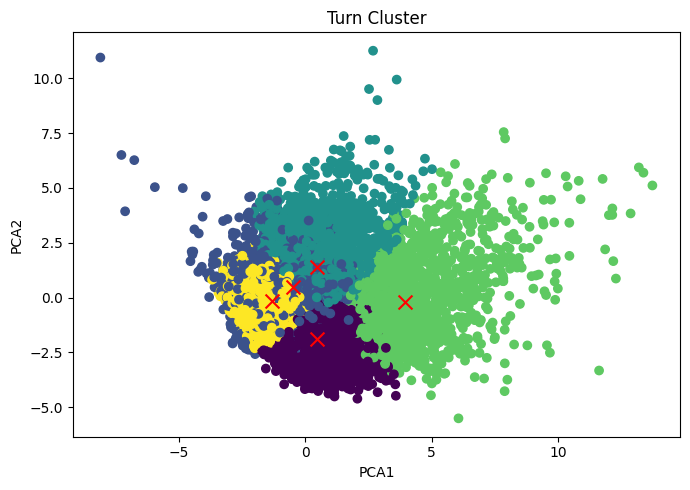

In [24]:
plt.figure(figsize=(7,5))

# Scatter plot
plt.scatter(reduced_X['PCA1'],reduced_X['PCA2'],c=kmeans.labels_)
plt.scatter(centers[:,0],centers[:,1],marker='x',s=100,c='red')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Turn Cluster')
plt.tight_layout()

In [25]:
sub_df_left.groupby('cluster').mean(numeric_only=True).T

cluster,0,1,2,3,4
eventDurationSeconds,3.391521,4.479556,8.240268,8.263223,3.737130
eventMilesDriven,0.017981,0.019642,0.031672,0.064568,0.010983
eventStartSpeed,17.047532,14.905291,11.980821,32.091299,9.323562
eventEndSpeed,18.877921,18.119066,16.049804,32.638295,11.487003
memsMedianHorizontalNorm,1.738584,2.984524,1.579087,1.839239,1.577462
gyro_angular_change_per_second,6.656463,17.422126,12.593451,8.215551,13.936813
gyroAngleChange,23.295815,76.847248,102.020467,66.715622,51.828942
mems_radius,63.525949,20.784812,25.680748,68.589337,15.564236


In [26]:
kmeans=KMeans(n_clusters=7)
kmeans.fit(X)
sub_df_left['cluster'] = kmeans.fit_predict(X)

In [27]:
pca=PCA(n_components=2)

reduced_X=pd.DataFrame(data=pca.fit_transform(X),columns=['PCA1','PCA2'])

#Reduced Features
reduced_X.head()

,PCA1,PCA2
0,-0.262817,0.351710
1,-0.681353,0.936549
2,-1.119123,0.261199
3,0.185473,0.834395
4,-0.359511,1.168559


In [28]:
centers=pca.transform(kmeans.cluster_centers_)

# reduced centers
centers

array([[ 0.57258555, -2.60650104],
       [-0.42653835,  0.34131956],
       [-1.04881373,  0.90532452],
       [ 5.61459523,  1.62537211],
       [-0.91780292, -1.18609073],
       [ 2.35117872, -1.25542041],
       [ 0.96891409,  1.31711593]])

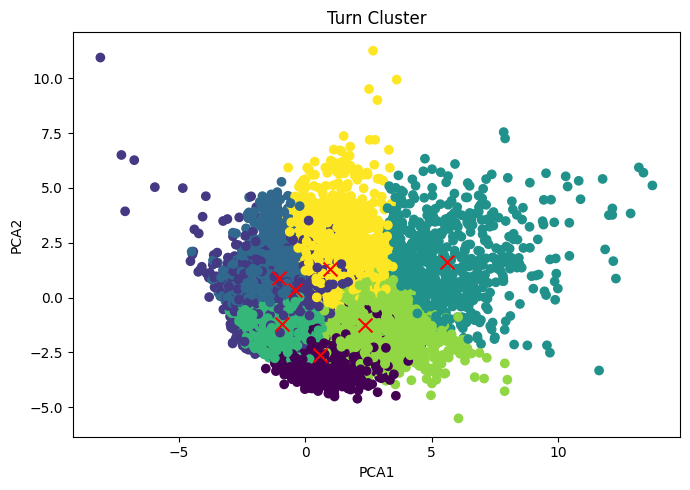

In [29]:
plt.figure(figsize=(7,5))

# Scatter plot
plt.scatter(reduced_X['PCA1'],reduced_X['PCA2'],c=kmeans.labels_)
plt.scatter(centers[:,0],centers[:,1],marker='x',s=100,c='red')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Turn Cluster')
plt.tight_layout()

In [30]:
sub_df_left.groupby('cluster').mean(numeric_only=True).T

cluster,0,1,2,3,4,5,6
eventDurationSeconds,3.227283,4.251536,5.347385,12.919179,2.740727,5.199183,8.735969
eventMilesDriven,0.015676,0.019546,0.015685,0.103581,0.011444,0.036494,0.036692
eventStartSpeed,13.456184,16.333489,8.460654,31.497835,12.365746,29.292309,13.548181
eventEndSpeed,15.643332,18.545511,12.438947,32.315354,13.913986,29.619250,17.960240
memsMedianHorizontalNorm,1.715753,3.213490,1.706305,1.507859,1.655314,1.931280,1.637715
gyro_angular_change_per_second,4.736134,17.501252,16.117042,7.785643,10.109388,8.356102,11.590052
gyroAngleChange,16.047327,72.660487,84.469663,100.281883,26.021621,43.599822,100.535468
mems_radius,109.286489,22.087208,14.244759,65.226777,24.975616,62.437558,31.220943


In [31]:
kmeans=KMeans(n_clusters=3)
kmeans.fit(X)
sub_df_left['cluster'] = kmeans.fit_predict(X)

In [32]:
pca=PCA(n_components=2)

reduced_X=pd.DataFrame(data=pca.fit_transform(X),columns=['PCA1','PCA2'])

#Reduced Features
reduced_X.head()

,PCA1,PCA2
0,-0.262817,0.351710
1,-0.681353,0.936549
2,-1.119123,0.261199
3,0.185473,0.834395
4,-0.359511,1.168559


In [33]:
centers=pca.transform(kmeans.cluster_centers_)

# reduced centers
centers

array([[-0.63722173, -1.36796041],
       [ 2.97871426, -0.31638038],
       [-0.46163178,  0.96014446]])

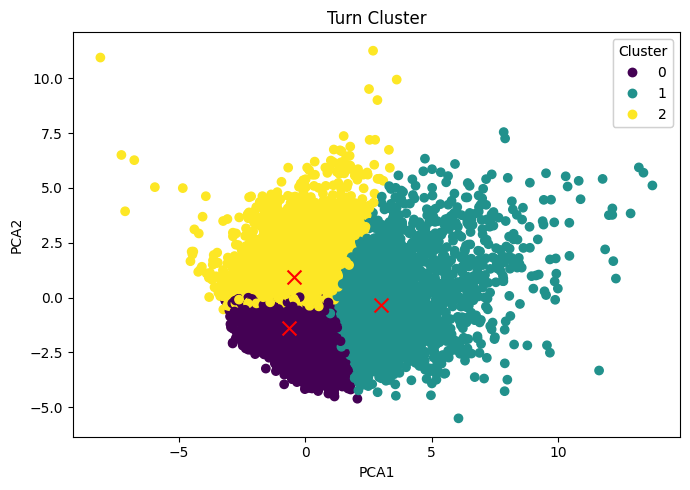

In [41]:
plt.figure(figsize=(7,5))
scatter = plt.scatter(
    reduced_X['PCA1'], reduced_X['PCA2'],
    c=kmeans.labels_, cmap='viridis'
)
plt.scatter(centers[:,0], centers[:,1], marker='x', s=100, c='red')

# Add legend showing which color corresponds to which cluster
legend = plt.legend(
    *scatter.legend_elements(),
    title="Cluster",
    loc="upper right"
)
plt.gca().add_artist(legend)

plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Turn Cluster")
plt.tight_layout()
plt.show()

In [35]:
sub_df_left.groupby('cluster').mean(numeric_only=True).T

cluster,0,1,2
eventDurationSeconds,2.829141,7.552313,5.879571
eventMilesDriven,0.012366,0.051612,0.021285
eventStartSpeed,13.263004,27.511449,11.577257
eventEndSpeed,14.878155,28.615158,15.281810
memsMedianHorizontalNorm,1.883800,1.842050,2.097363
gyro_angular_change_per_second,9.774298,8.493464,15.869783
gyroAngleChange,25.745292,63.895708,88.628259
mems_radius,37.697339,65.060482,18.948200
